In [1]:
import numpy as np

In [2]:
f = open('ce11.fa', 'r')
gene_1 = ''
f.readline()
for line in f.readlines():
    if line[0] == '>':
        break
    gene_1 = gene_1 + line[:-1].upper()
f.close()

f = open('cb4.fa', 'r')
gene_2 = ''
f.readline()
for line in f.readlines():
    if line[0] == '>':
        break
    gene_2 = gene_2 + line[:-1].upper()
f.close()

print(len(gene_1), len(gene_2))

15072434 15455979


In [3]:
seeds = np.load('seeds.npy')
print(len(seeds))
print(seeds[:10])

127518
[[     280 10306376]
 [    1070 10307154]
 [    2541 10307878]
 [    2661 12782807]
 [    2661 12783128]
 [    3927  3485503]
 [    3927  3485843]
 [    3927  3486163]
 [    3927  3486483]
 [    3927  3486803]]


In [4]:
W = {'A': {'A':  91, 'C': -90, 'G': -25, 'T':-100},
     'C': {'A': -90, 'C': 100, 'G':-100, 'T': -25},
     'G': {'A': -25, 'C':-100, 'G': 100, 'T': -90},
     'T': {'A':-100, 'C': -25, 'G': -90, 'T':  91}}
g_o = -430
g_e = -30

num_PE = 64
Band = 32
tile_size = 320
threshold = 8000

In [5]:
def SW(gene_1, gene_2, W, g_o, g_e):
    # Initial
    tile_size = min(len(gene_1), len(gene_1))
    V = np.zeros((tile_size+1, tile_size+1))
    I = np.zeros((tile_size+1, tile_size+1))
    D = np.zeros((tile_size+1, tile_size+1))
#     Trace = np.zeros((tile_size+1, tile_size+1), dtype=int)
#     Trace_I = np.zeros((tile_size+1, tile_size+1), dtype=int)
#     Trace_D = np.zeros((tile_size+1, tile_size+1), dtype=int)
    V_max = float('-inf')
    x_max, y_max = 0, 0
    
    column_start = 1
    column_end = 1
    # Calculate
    for i in range(1, tile_size+1, num_PE):
        column_start = max(1, (i//num_PE)*num_PE+1-Band)
        column_end = min(tile_size, (i//num_PE+1)*num_PE+Band)
        column = column_start # current column
        while column <= column_end:
            # row index: i+j, column index:column
            for j in range(num_PE):
                if i+j > tile_size:
                    break
                V_nxt = V[i+j-1][column-1] + W[gene_1[i+j-1]][gene_2[column-1]]
                I[i+j][column] = max(V[i+j][column-1]+g_o, I[i+j][column-1]+g_e, 0)
                D[i+j][column] = max(V[i+j-1][column]+g_o, D[i+j-1][column]+g_e, 0)
                V[i+j][column] = max(V_nxt, I[i+j][column], D[i+j][column], 0)
                # track max score
                if V[i+j][column] >= V_max:
                    V_max = V[i+j][column]
                    x_max, y_max = i+j, column
                # track direction
#                 if V[i+j][column] == 0:
#                     Trace[i+j][column] = 0
#                 elif V[i+j][column] == V_nxt:
#                     Trace[i+j][column] = 1
#                 elif V[i+j][column] == D[i+j][column]:
#                     Trace[i+j][column] = 2
#                 elif V[i+j][column] == I[i+j][column]:
#                     Trace[i+j][column] = 3
#                 # direction of Trace_I
#                 if I[i+j][column] == V[i+j][column-1]+g_o:
#                     Trace_I[i+j][column] = 1
#                 else:
#                     Trace_I[i+j][column] = 0
#                 # direction of Trace_D
#                 if D[i+j][column] == V[i+j-1][column]+g_o:
#                     Trace_D[i+j][column] = 1
#                 else:
#                     Trace_D[i+j][column] = 0
            # if stripe end
            column += 1
    return V_max, x_max, y_max

In [6]:
pattern = '1110100110010101111'
def check_hit(seq1, seq2, pattern):
    for i in range(len(pattern)):
        if ((pattern[i] == '1') or (pattern[i] == 1)) and not (seq1[i] == seq2[i]):
            return False
    return True

In [7]:
f = open('anchor.txt', 'w')

In [8]:
scores = []
for i in range(len(seeds)):
    print('\r', end='')
    print(f'Processing seeds: {i+1}/{len(seeds)}', end='')
    if (seeds[i][0] < tile_size//2) or (seeds[i][1] < tile_size//2):
        scores.append(0)
        continue
    seed_1 = gene_1[seeds[i][1] : seeds[i][1]+19]
    seed_2 = gene_2[seeds[i][0] : seeds[i][0]+19]
    seq_1 = gene_1[seeds[i][1]-tile_size//2 : seeds[i][1]+tile_size//2]
    seq_2 = gene_2[seeds[i][0]-tile_size//2 : seeds[i][0]+tile_size//2]
    
    # print(check_hit(seed_1, seed_2, pattern))
    if ("N" in seq_1) or ("N" in seq_2):
        scores.append(0)
        continue
    score, x, y = SW(seq_1, seq_2, W, g_o, g_e)
    x += seeds[i][1]-tile_size//2
    y += seeds[i][0]-tile_size//2
    scores.append(score)
    if score > threshold:
        f.write(f"{x} {y} {score}\n")

Processing seeds: 127518/127518

In [9]:
f.close()

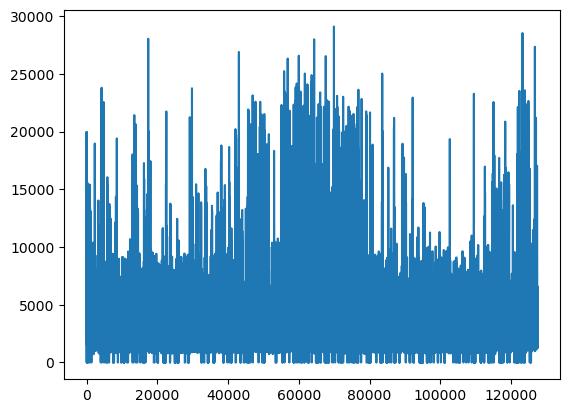

In [10]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.show()